# First pass at EDA after data migrated to Postgres
28 September 2017

In [236]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import re
from dateutil.parser import parse
import spacy
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence

%matplotlib inline

In [262]:
df = pd.read_pickle('../data/second_postgres.pkl')
df['word_count'] = [len(x.split()) if x is not None else 0 for x in df.body]

In [263]:
to_update = []

In [264]:
weird_dates = df[(df.pub_time < pd.Timestamp.min) | (df.pub_time > datetime.datetime.now())]
to_update.append(weird_dates.url)
df.loc[weird_dates.index]['pub_time'] = None

In [265]:
def url_regex(i, df):
    date = re.findall('/(\d{4}/\d{2}/\d{2})', df.loc[i]['url'])
    if date:
        df.loc[i,'pub_time'] = parse(date[0])

In [266]:
null_dates = df[df.pub_time.isnull()]
to_update.append(null_dates.url)
for i, row in null_dates.iterrows():
    url_regex(i, df)

In [267]:
crazy_dates = df[df.pub_time < datetime.datetime(1990, 1, 1)]
to_update.append(crazy_dates.url)
for i, row in crazy_dates.iterrows():
    url_regex(i, df)
    if (df.loc[i,'pub_time'].year + 100) > 2000:
        df.loc[i,'pub_time'] = datetime.datetime(df.loc[i,'pub_time'].year + 100, 
                                                 df.loc[i,'pub_time'].month, 
                                                 df.loc[i,'pub_time'].day)
    else:
        df.loc[i,'pub_time'] = None

In [268]:
df = df[(df.pub_time).notnull()]

In [120]:
min_date = min(df.pub_time).date()
max_date = max(df.pub_time).date()
print(min_date, max_date)

2000-01-01 2017-09-28


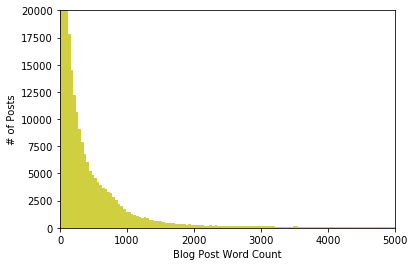

In [4]:
plt.axis([0, 5000, 0, 20000])
plt.xlabel('Blog Post Word Count')
plt.ylabel('# of Posts')
# plt.grid(True)
plt.hist(df.word_count, 10000, facecolor='y', alpha=0.75);

In [5]:
grouped = df.groupby('blog_url').count()
grouped.reset_index(inplace=True)
grouped.rename(columns={'url':'post_count'},inplace=True)
grouped = pd.concat([grouped.blog_url, grouped.post_count], axis=1)
grouped.sort_values(by='post_count',ascending=False, inplace=True)
grouped.reset_index(inplace=True, drop=True)

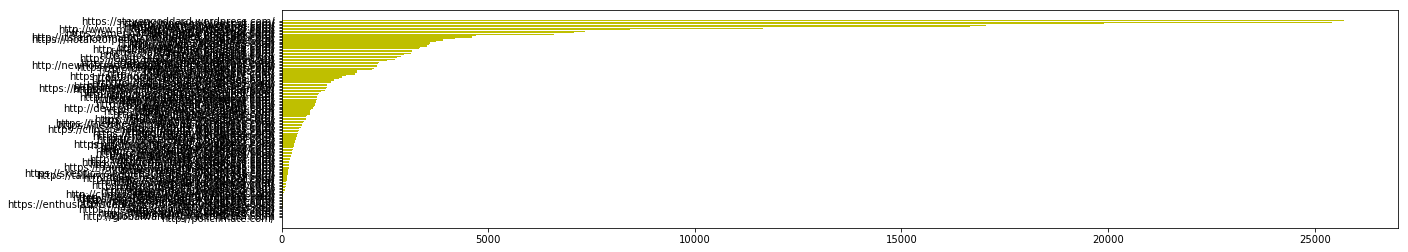

In [186]:
fig, ax = plt.subplots(figsize=(20, 4))
rects2 = ax.barh(grouped.index, grouped.post_count, color='y');
ax.set_yticks(grouped.index)
ax.set_yticklabels(grouped.blog_url);
ax.invert_yaxis()  # labels read top-to-bottom

In [125]:
ix = pd.DatetimeIndex(start=min_date, end=max_date, freq='M')

def compile_monthly(blog_url, df):
    blog_posts = df[df.blog_url == blog_url]
    blog_posts = blog_posts.set_index(pd.DatetimeIndex(blog_posts['pub_time']))    
    blog_posts = blog_posts.resample('M').count()['url']
    blog_posts = blog_posts.reindex(ix, fill_value=0)
    return blog_posts.values

In [280]:
blog_start_date = df.groupby('blog_url').agg('min')
blog_start_date.sort_values(by='pub_time',ascending=True, inplace=True)
blog_start_date.reset_index(inplace=True)


In [281]:
posts = []
for blog_url in blog_start_date.blog_url:
    posts.append(compile_monthly(blog_url, df))

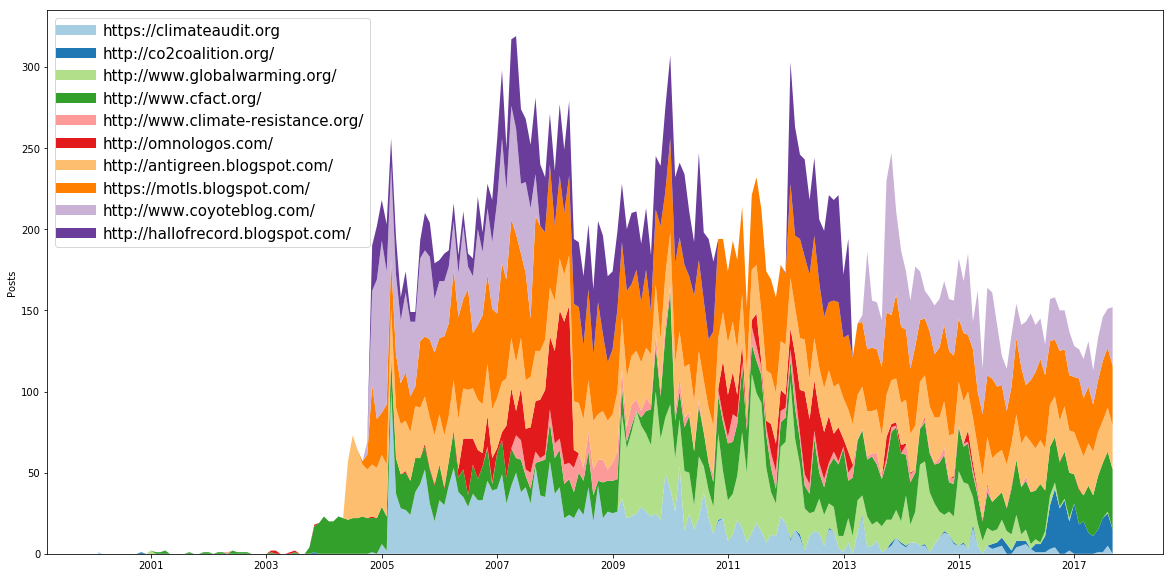

In [285]:
color_list = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']

fig, ax = plt.subplots(figsize=(20,10));
ax.stackplot(ix, posts[0:10], colors = color_list[0:10]);

for i in range(10):
    plt.plot([],[],color=color_list[i], label=blog_start_date.loc[i]['blog_url'],linewidth=10)

plt.ylabel('Posts')
plt.legend(loc='upper left', fontsize=15)